# TP3 - Genetic Programming

In this last set of exercises, we are going to take a look at Genetic Programming, the most recent and more versatile technique belonging to the field of Evolutionary Computation. First, let's install [GPLearn, a Python library for Genetic Programming](https://gplearn.readthedocs.io/en/stable/), specifically tailored for Symbolic Regression.

In [1]:
!pip install gplearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Symbolic regression with GPLearn
Since we are going to work on Symbolic Regression, we will need some data, representing a sampling of a function we want to approximate. The function used to generate the dataset is:

$y = x_1 \cdot sin(2x_1) - sin(2x_1)$

$y = (x_1-1) \cdot sin(2x_1)$

with some noise added, in order to make the regression problem harder.

Text(0, 0.5, 'y')

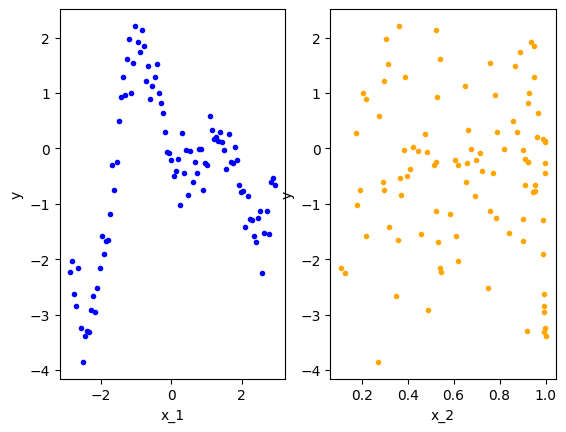

In [2]:
import pandas as pd # Pandas is a library with helpful functions for loading and managing datasets

csv_address = "https://raw.githubusercontent.com/albertotonda/teaching/master/gp-symbolicRegression-data.csv"
dataframe = pd.read_csv(csv_address)
y = dataframe["y"].values
X = dataframe[["x_1", "x_2"]].values  

x_1 = X[:,0]
x_2 = X[:,1]

# let's look at the 'y' variable, that we would like to approximate in function of the other two ('x_1', 'x_2')
# first, 'y' in function of 'x_1'
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(x_1, y, '.', color='blue')
plt.xlabel("x_1")
plt.ylabel("y")

# then, 'y' in function of 'x_2' (you might notice that the result does not seem to make much sense)
plt.subplot(1,2,2)
plt.plot(x_2, y, '.', color='orange')
plt.xlabel("x_2")
plt.ylabel("y")

As you might notice, even though $y$ is just in function of $x_1$, the dataset contains a second variable $x_2$, which is not correlated to $y$ at all: it's just added to make the task harder for an algorithm that will try to learn the relationship between the variables $x_1, x_2$ and $y$ (or, in other words, $y = f(x_1, x_2)$).

We can now start a first experiment on symbolic regression; in order to get a solid evaluation of the result, we will first need to split the data between training and test, so that the test is unseen by the algorithm during the training process, and can be used as a final validation.

The split between training set and test set is typical for machine learning applications (even non-evolutionary). Algorithms that can learn from data have the tendency of learning patterns in the training data that are only valid for that particular training data (for example, random noise). An algorithm that learns these patterns is unable to generalize its performance to unseen data: it will perform much better on the training data than on other data. This phenomenon is called [overfitting](https://en.wikipedia.org/wiki/Overfitting).

The reason why we also create a test set is to have unseen data that can be used *after* the learning process, to assess the generalization ability of the algorithm. If the algorithm performs well on both training data and test data, it's an indication that it was able to learn general principles. If the algorithm performs much better on the training data than on the test data, it's an indication that the algorithm learnt patterns that are only found in the training data, and it is thus worse at generalizing due to overfitting.

In [3]:
# split the data between training and test, using 33% of the data for test
from sklearn.model_selection import train_test_split # 'sklearn', scikit-learn, is a library with tools for machine learning and manipulating data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # random_state here is a random seed, fixed so that we always get the same results

Let's proceed with a first test! We launch the Symbolic Regression algorithm on the training data, and then test the best individual on the test data. We are going to use a metric called "Mean Squared Error" (MSE) to evaluate the goodness of the results (also, as a fitness function). A lower value of MSE is better, ideally zero would be optimal; however we likely won't be able to reach exactly zero.

In [4]:
# create a SymbolicRegressor object
from gplearn.genetic import SymbolicRegressor
sr = SymbolicRegressor(
        population_size=50,
        generations=20,
        stopping_criteria=0.01,	# stop if the mean squared error of the best solution is lower than this
        feature_names=["x_1", "x_2"], # this is just to give custom names to the variables
        function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos'), # functions that the symbolic regression can use
        p_crossover=0.7, 	# probabilities of activation of different genetic operators
        p_subtree_mutation=0.1,	#
        p_hoist_mutation=0.05, 	#
        p_point_mutation=0.1,	#
        verbose=1,		# print a lot of stuff to screen
        parsimony_coefficient=0.01,	# penalize large trees (so, complex solutions)
        random_state=42
      )

# launch the evolution
sr.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    18.98          2.86757       26          1.04485              N/A      0.76s
   1     9.56           1.3048       12         0.939087              N/A      0.74s
   2     8.02          1.22935       14         0.923631              N/A      0.73s
   3     8.58          1.26102        4           0.9372              N/A      0.79s
   4     3.62          1.10994        4           0.9372              N/A      0.66s
   5     2.48          1.15446        3         0.939683              N/A      0.54s
   6     2.06          1.09891        2         0.949223              N/A      0.53s
   7     2.62          1.15185        2         0.949223              N/A      0.40s
   8     2.22          1.08207        2         0.949223              N/A  

SymbolicRegressor(feature_names=['x_1', 'x_2'],
                  function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos'),
                  p_crossover=0.7, p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=50, random_state=42, stopping_criteria=0.01,
                  verbose=1)

Now that this first run is over, let's take a look at the quality of the results, and at the shape of the best tree/equation found.

MSE for training data: 1.3841; MSE for test data: 1.3490
Best tree: cos(x_1)


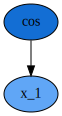

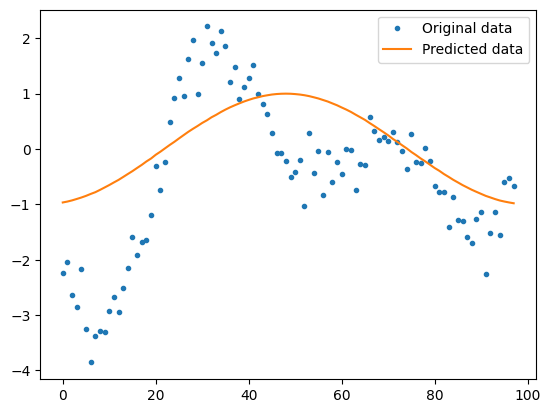

In [5]:
# we could write our own function to compute the MSE, but the scikit-learn (sklearn) library already has lots of functions implemented
from sklearn.metrics import mean_squared_error
y_train_predicted = sr.predict(X_train)
y_test_predicted = sr.predict(X_test)
mse_train = mean_squared_error(y_train_predicted, y_train)
mse_test = mean_squared_error(y_test_predicted, y_test)

print("MSE for training data: %.4f; MSE for test data: %.4f" % (mse_train, mse_test))
print("Best tree:", sr._program)

# let's compare the data predicted by the best tree, versus the original data
plt.plot(y, '.', label="Original data")
plt.plot(sr.predict(X), label="Predicted data")
plt.legend(loc='best')

# we can also visualize the tree, using the graphviz library
import graphviz
dot_data = sr._program.export_graphviz() # exports the tree in the graphviz format
graphviz.Source(dot_data) # prints out the shape of the binary tree

In this first attempt, you can probably see that the results are not great. The algorithm has a similar performance on training data and test data, which means that it generalizes relatively well, but its performance is mediocre.

Try to modify the parameters of SymbolicRegressor to obtain better results, like you would for any evolutionary algorithm. For reference, a "good" value of MSE for this data is less than 0.3. Once you obtain good results, what do you notice about the final tree? Are all the input variables ($x_1$, $x_2$) used?

After getting good results, try changing the value for the **parsimony_coefficient**, that controls bloating, and thus pushes for larger or smaller trees. Notice how the final solution will change, depending on the value you set.

As a final exercise with GPLearn, try to find good results for another dataset. Here below we have a classic example, the prices of houses in California, in function of different variables, such as per capita crime or percentage of the population of lower status.

But if you'd like to use another regression dataset, go for it! [You can find instructions on how to load datasets to Colaboratory here.](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92) Or, you can [use the openml library](https://openml.github.io/openml-python/master/#example) to load one of the many available [datasets for regression](https://www.openml.org/search?q=+tasktype.tt_id%3A2&type=task).

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

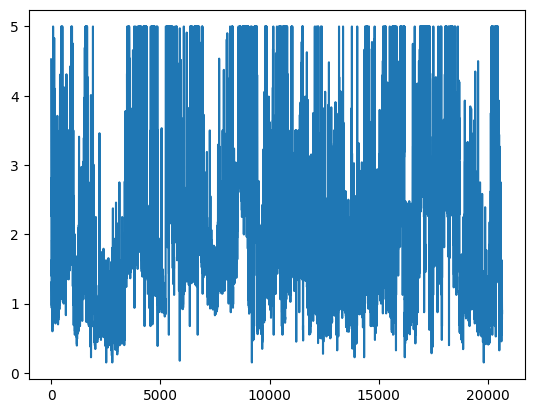

In [6]:
from sklearn.datasets import fetch_california_housing

# load inputs (X) and target (y) for the dataset, then print its description and plot to screen
dataset = fetch_california_housing()
y = dataset.target
X = dataset.data

print(dataset.DESCR)

import matplotlib.pyplot as plt
plt.plot(y)

# you can write the rest of your code here below

In [7]:
# if you decide to use openml, run this code first
!pip install openml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 9.4 MB/s eta 0:00:00
  Created wheel for openml: filename=openml-0.13.1-py3-none-any.whl size=142784 sha256=2a07e02147369b6f0c64ef1179d55425c3acb572edc89af9a208f3a3abe82b69
  Stored in directory: /root/.cache/pip/wheels/f7/7a/fa/f73edc5ccecbab13bbf5fb888f2f943720f77114a1fa4ceffe
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=7e1093923d8fc91be11bfa6de1eb241238e279528e71bbf88a6ca3bfa299f755
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built openml liac-arff


## Symbolic regression with Eureqa
In this second part, we are going to take a look at a commercial software for symbolic regression, that has been optimized for efficiency. You can download a trial version from these links:
- [Eureqa for Windows](https://drive.google.com/file/d/1U2PG8Kmlu2r7l-Myis8h88bLhRQ695sM/view?usp=sharing) (64 bit)
- [Eureqa for Linux](https://drive.google.com/file/d/1aTBvIDU2_J_4XyFx2EWgj8JL0wHxuGUJ/view?usp=sharing) (x86-64)
- [Eureqa for Linux](https://drive.google.com/file/d/1fdNEDbmgFw8w1BhqFpcushzasOfIsQdf/view?usp=sharing) (32 bit)

Be careful about the data format, sometimes you will need to change the system notation for numbers from European ("13,1214") to US/Anglo-saxon ("13.1214"). 

Try to run Eureqa with the data showing up when you open the program (that is the same dataset used in the first example with GPLearn). Notice the solution that Eureqa uses for managing bloating (see graph in the bottom right corner of this screenshot).

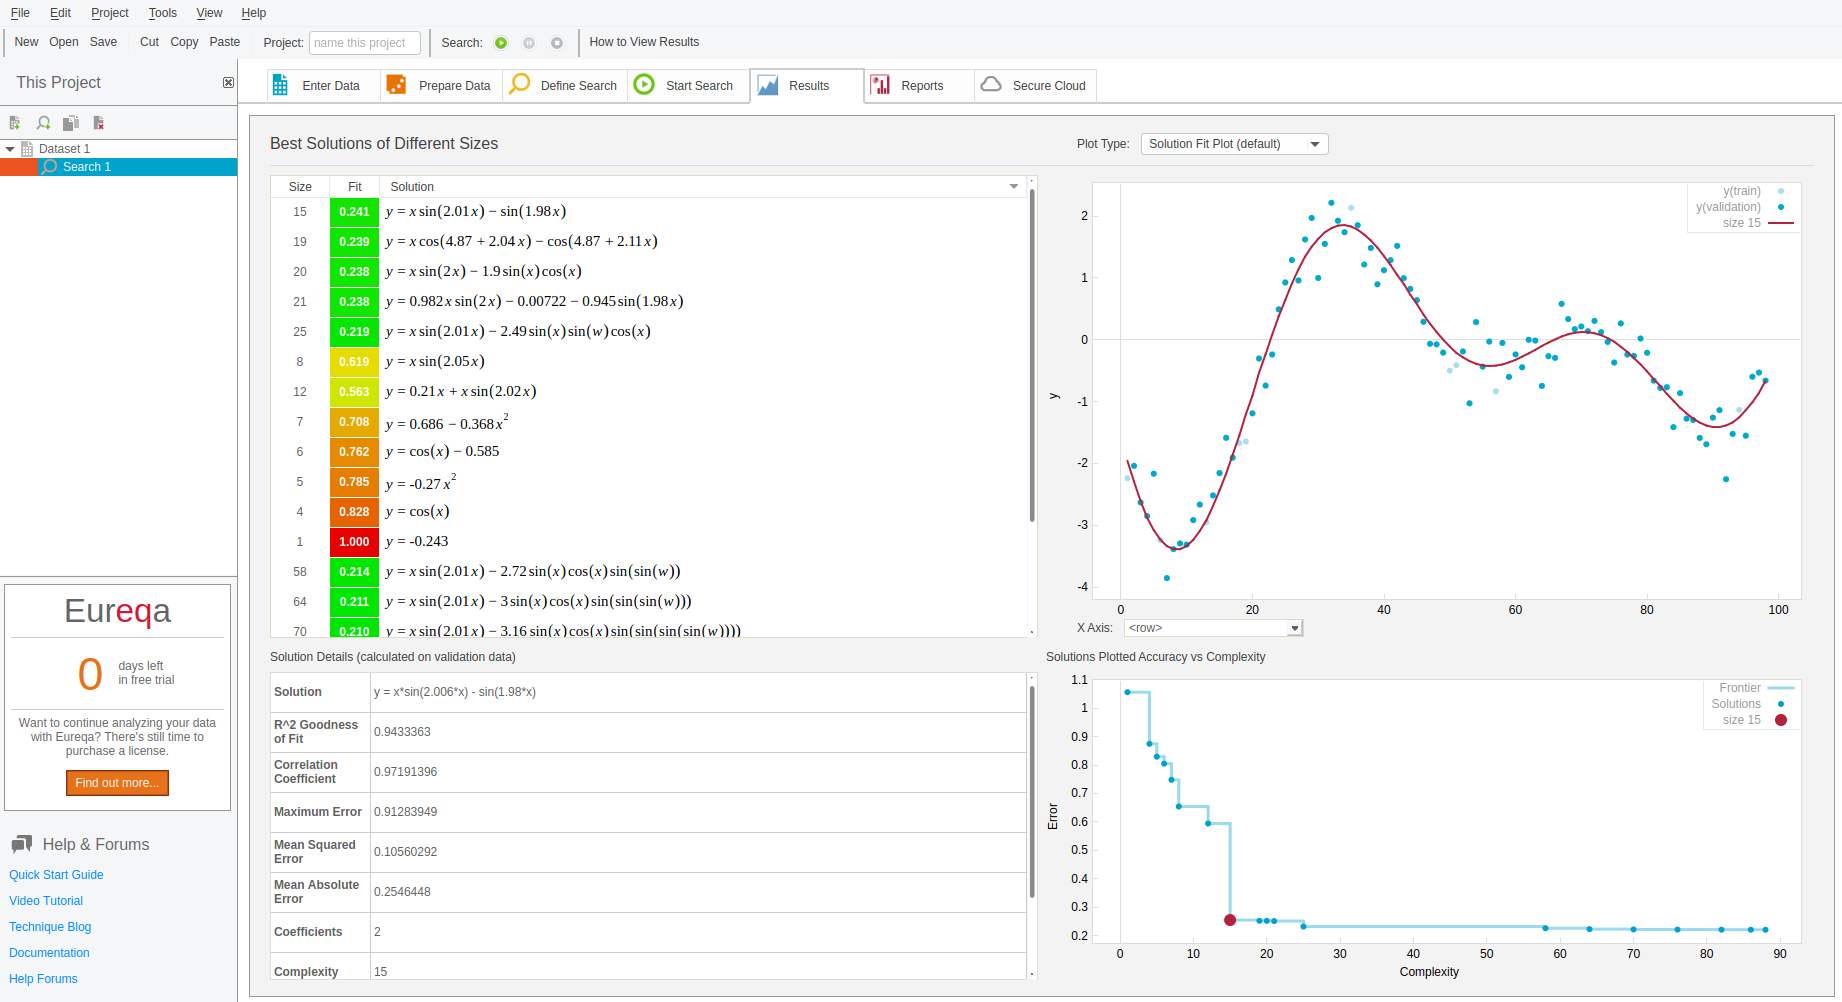

Then, try Eureqa on the second dataset you selected.

## Symbolic regression with PySR
There are other modules for symbolic regression in Python. PySR is an open-source library that uses a technique similar to Eureqa's to find compromises between complexity and fitting.

However, it was originally written in the programming language Julia, and later ported to Python. Even after several valiant efforts, I was not able to make it run under Google Colab ^_^; so if you'd like to give it a try, here is the GitHub repository with instructions to install it on your local machine: https://github.com/MilesCranmer/PySR

As of **June 2023**, the easiest way of installing PySR is by using `conda` under Linux, and follow the instructions on the GitHub repository page for Windows and MacOS.